# RNN_금융앱리뷰_분석

In [2]:
# !pip install konlpy

In [1]:
from konlpy.tag import Mecab
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.utils import to_categorical

2025-05-22 14:02:09.418218: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 14:02:09.453612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747890129.503418    6300 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747890129.519838    6300 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747890129.552964    6300 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
train_data = pd.read_csv("./data/bank_app_reviews_train.csv")
train_data.head()

,리뷰일,평점,사용자리뷰,업체답변,은행명
0,2023-12-21,5,엄빠 폰에 설치해드렸는데 두분 다 쓰기 편하다고 하시네요 ㅎㅎ 저도 쓰고있음!,NaN,하나
1,2025-02-17,1,Cd기 축소 연장하려면 이 어플 깔라는데 왜 30퍼에서 안깔리는지 아니 애초에 슈퍼...,안녕하세요. 신한은행입니다.\n먼저 SOL사용에 불편을 드려 죄송합니다.\n어플의 ...,신한
2,2024-07-26,5,서비스가 통합되어 있어서 점점 사용빈도가 높아지네요.,고객님 안녕하세요! KB스타뱅킹을 이용해 주셔서 진심으로 감사드립니다. KB스타뱅킹...,국민
3,2024-09-01,1,카드 충천이 안됌,"안녕하세요. 전민구 님, 토스팀입니다. 남겨주신 내용만으로는 겪고계신 불편사항의 자...",토스
4,2023-11-13,1,알뜰폰 인증이 안돼요.....,"안녕하세요 헤이모두들안녕님, 우리은행입니다. 먼저 이용에 불편을 드려 매우 죄송합니...",우리


### 특수문자 제거 함수

In [3]:
import re

def clean_text(text):
    cleaned = re.sub(r'[^가-힣a-zA-Z0-9\s]','', text) #한글, 영문, 숫자
    cleaned = re.sub(r'\s+', ' ', cleaned) # 연속된 공백을 하나의 공백
    return cleaned.strip()

### 사용자 리뷰에서 특수문자 제거

In [4]:
train_data['사용자리뷰'] = train_data['사용자리뷰'].apply(clean_text)
train_data['사용자리뷰']

0                  엄빠 폰에 설치해드렸는데 두분 다 쓰기 편하다고 하시네요 저도 쓰고있음
1        Cd기 축소 연장하려면 이 어플 깔라는데 왜 30퍼에서 안깔리는지 아니 애초에 슈퍼...
2                             서비스가 통합되어 있어서 점점 사용빈도가 높아지네요
3                                                카드 충천이 안됌
4                                              알뜰폰 인증이 안돼요
                               ...                        
22241                                      어플 시작오류가 가끔 나네요
22242                              업데이트 후에 계좌이체하는 게 자주 튕겨요
22243                                                  굳굳굳
22244                                  오래시간 같이한 나의은행 든든합니다
22245    라이브 광고 전보다 더 안좋네 아무리 주기 싫어도 겨우 3원줄거면서 너무 쪼잔하게 ...
Name: 사용자리뷰, Length: 22246, dtype: object

### is_good 컬럼 추가
- 평점 4이상은 긍정(1)
- 3이하는 부정(0)

In [5]:
train_data['is_good'] = train_data['평점'].apply(lambda x: 1 if x >=4 else 0)
train_data['is_good']

0        1
1        0
2        1
3        0
4        0
        ..
22241    0
22242    0
22243    1
22244    1
22245    0
Name: is_good, Length: 22246, dtype: int64

### 토큰화

In [6]:
train_data['사용자리뷰']

0                  엄빠 폰에 설치해드렸는데 두분 다 쓰기 편하다고 하시네요 저도 쓰고있음
1        Cd기 축소 연장하려면 이 어플 깔라는데 왜 30퍼에서 안깔리는지 아니 애초에 슈퍼...
2                             서비스가 통합되어 있어서 점점 사용빈도가 높아지네요
3                                                카드 충천이 안됌
4                                              알뜰폰 인증이 안돼요
                               ...                        
22241                                      어플 시작오류가 가끔 나네요
22242                              업데이트 후에 계좌이체하는 게 자주 튕겨요
22243                                                  굳굳굳
22244                                  오래시간 같이한 나의은행 든든합니다
22245    라이브 광고 전보다 더 안좋네 아무리 주기 싫어도 겨우 3원줄거면서 너무 쪼잔하게 ...
Name: 사용자리뷰, Length: 22246, dtype: object

In [20]:
# !pip install mecab-python3

In [7]:
mecab = Mecab()
mecab.morphs(train_data['사용자리뷰'][0])

['엄',
 '빠',
 '폰',
 '에',
 '설치',
 '해',
 '드렸',
 '는데',
 '두',
 '분',
 '다',
 '쓰',
 '기',
 '편하',
 '다고',
 '하',
 '시',
 '네요',
 '저',
 '도',
 '쓰',
 '고',
 '있',
 '음']

### 전체 문장을 토큰화 한 후 tokenized_docs에 저장

In [8]:
tokenized_docs = train_data['사용자리뷰'].apply(mecab.morphs)

In [9]:
tokenized_docs[2]

['서비스',
 '가',
 '통합',
 '되',
 '어',
 '있',
 '어서',
 '점점',
 '사용',
 '빈도',
 '가',
 '높',
 '아',
 '지',
 '네요']

### 단어 인덱스 생성

In [10]:
token = Tokenizer(lower=False)
token.fit_on_texts(tokenized_docs)
print(len(token.word_index))

13010


### 문장 벡터화

In [11]:
x = token.texts_to_sequences(tokenized_docs)
print(x[0])

[5400, 1682, 170, 11, 159, 37, 2292, 14, 301, 184, 28, 45, 19, 106, 123, 1, 76, 15, 216, 5, 45, 2, 10, 64]


### 가장 긴 문장의 길이 구하기

In [12]:
max_length = max([len(i) for i in x]) + 1
max_length

302

### 가장 긴 길이에 맞춰서 패딩
- RNN의 경우 패딩을 post로 주는 것이 더 좋음, 단어가 앞, 0이 뒤에 붙음
- Transformer계열은 위치 정보가 따로 있으므로 post, pre든 차이가 없음

In [13]:
X_padded = pad_sequences(x, maxlen=max_length, padding='post')
print(X_padded[1])

[7174   19 2404 1948    1  414    3   18   52  210 1258   51  521 1604
   42    6 3601  143   90 1518   11  725  553 1003  114    3   18   52
  435    2  725  923   11   94  221   18   29  485   51 4003 4523 4004
   58  277   77  725  923  923  251   28  210   13  366    4   39  250
 2830  332    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [14]:
X_padded.shape

(22246, 302)

In [15]:
y = train_data['is_good']
y.value_counts()

is_good
1    13240
0     9006
Name: count, dtype: int64

### 홀드아웃 : X,y 데이터 나누기

In [17]:
# !pip install scikit-learn

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X_padded, y, test_size=0.3, stratify=y, random_state=42)

In [18]:
# 임베딩에 입력할 단어 수 추출
word_size = len(token.word_index) + 1
print(word_size)

13011


In [19]:
import joblib

In [84]:
joblib.dump(token, "./model//bank_app_tokenizer.joblib")
joblib.dump(max_length, "./model/bank_app_max_length.joblib")

['./model/bank_app_max_length.joblib']

# 양방향 RNN 네트워크를 이용해 텍스트 분석

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [21]:
birnn = Sequential()
birnn.add(Input(shape=(max_length,)))
birnn.add(Embedding(input_dim=word_size, output_dim=64))
birnn.add(Bidirectional(SimpleRNN(128, return_sequences=False, activation='tanh')))
birnn.add(Dense(32, activation='relu'))
birnn.add(Dropout(0.5))
birnn.add(Dense(1, activation='sigmoid'))
birnn.summary()


I0000 00:00:1747890157.768403    6300 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1347 MB memory:  -> device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 302, 64)        │       832,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 890,369 (3.40 MB)

 Trainable params: 890,369 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
birnn.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
model_path = "./model/bank_app_review_birnn.keras"
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                            save_best_only=True,
                            verbose=1)
birnn_history = birnn.fit(X_train, y_train, epochs=1000, batch_size=256,
                         validation_data=(X_valid, y_valid),
                         callbacks=[early_stop, checkpoint])


Epoch 1/1000


I0000 00:00:1747890172.356704    6347 service.cc:152] XLA service 0x7f123c00ed90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747890172.356784    6347 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2025-05-22 14:02:52.498002: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747890173.280516    6347 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747890181.623488    6347 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.7105 - auc: 0.7703 - loss: 0.5526
Epoch 1: val_loss improved from inf to 0.30752, saving model to ./model/bank_app_review_birnn.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 49s 573ms/step - accuracy: 0.7118 - auc: 0.7717 - loss: 0.5512 - val_accuracy: 0.8791 - val_auc: 0.9399 - val_loss: 0.3075
Epoch 2/1000
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8928 - auc: 0.9408 - loss: 0.2995
Epoch 2: val_loss improved from 0.30752 to 0.27086, saving model to ./model/bank_app_review_birnn.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 417ms/step - accuracy: 0.8929 - auc: 0.9409 - loss: 0.2993 - val_accuracy: 0.8923 - val_auc: 0.9523 - val_loss: 0.2709
Epoch 3/1000
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9301 - auc: 0.9649 - loss: 0.2191
Epoch 3: val_loss did not improve from 0.27086
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 383ms/step - accuracy: 0.9300 - auc: 0.9649 - loss: 0.2192 - val_accuracy: 0.7953 - val_auc: 0.9461 - val_loss: 0.4053
Epoch 

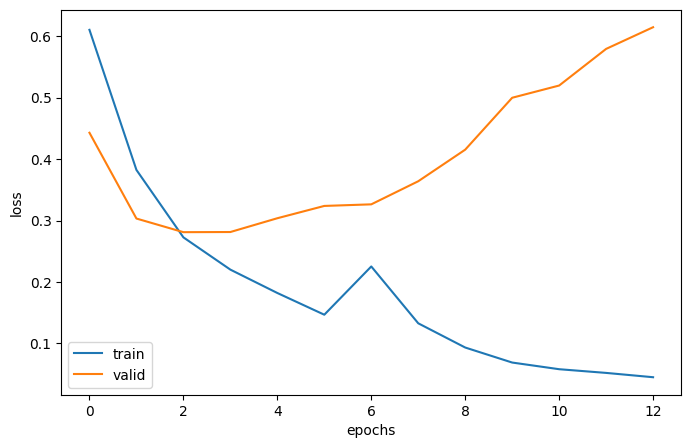

In [43]:
plt.figure(figsize=(8, 5))
plt.plot(birnn_history.history['loss'])
plt.plot(birnn_history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'valid'])
plt.show()

In [44]:
print(birnn.evaluate(X_valid, y_valid))

209/209 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.8910 - auc: 0.9538 - loss: 0.2731
[0.28107866644859314, 0.8885226249694824, 0.9504384398460388]


In [45]:
pred = birnn.predict(X_valid)
pred

209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step


array([[0.98676604],
       [0.90154105],
       [0.04848124],
       ...,
       [0.94064844],
       [0.10994254],
       [0.9535726 ]], dtype=float32)

In [46]:
pred.shape

(6674, 1)

In [47]:
pred = pd.DataFrame(pred)

In [48]:
y_valid = pd.DataFrame(y_valid.reset_index(drop=True))
y_valid

,is_good
0,1
1,1
2,0
3,1
4,0
...,...
6669,0
6670,1
6671,1
6672,0


In [49]:
result = pd.concat([y_valid, pred], axis=1)
result

,is_good,0
0,1,0.986766
1,1,0.901541
2,0,0.048481
3,1,0.989154
4,0,0.059792
...,...,...
6669,0,0.080075
6670,1,0.925932
6671,1,0.940648
6672,0,0.109943


In [50]:
result.columns = ['is_good', 'pred']
result

,is_good,pred
0,1,0.986766
1,1,0.901541
2,0,0.048481
3,1,0.989154
4,0,0.059792
...,...,...
6669,0,0.080075
6670,1,0.925932
6671,1,0.940648
6672,0,0.109943


In [51]:
result['pred'] = result['pred'].apply(lambda x: 1 if x > 0.5 else 0)

In [52]:
from sklearn.metrics import classification_report
print(classification_report(result['is_good'], result['pred']))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2702
           1       0.90      0.92      0.91      3972

    accuracy                           0.89      6674
   macro avg       0.89      0.88      0.88      6674
weighted avg       0.89      0.89      0.89      6674



# LSTM과 CNN 조합 모델로 분석

In [53]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, GlobalMaxPooling1D

In [54]:
lstm_cnn = Sequential()
lstm_cnn.add(Input(shape=(max_length,)))
lstm_cnn.add(Embedding(input_dim=word_size, output_dim=128))
lstm_cnn.add(Dropout(0.3))
lstm_cnn.add(Conv1D(128, 5, padding='valid', activation='relu'))
lstm_cnn.add(MaxPooling1D(pool_size=4))
lstm_cnn.add(Conv1D(128, 5, padding='valid', activation='relu'))
lstm_cnn.add(MaxPooling1D(pool_size=4))
lstm_cnn.add(Bidirectional(LSTM(256, return_sequences=True)))
lstm_cnn.add(GlobalMaxPooling1D())
lstm_cnn.add(Dense(64, activation='relu'))
lstm_cnn.add(Dropout(0.3))
lstm_cnn.add(Dense(32, activation='relu'))
lstm_cnn.add(Dense(1, activation='sigmoid'))
lstm_cnn.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 302, 128)       │     1,665,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 302, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 298, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 74, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 70, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 17, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 17, 512)        │       788,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,652,929 (10.12 MB)

 Trainable params: 2,652,929 (10.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


2025-05-22 11:47:18.039255: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-22 11:47:18.187314: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7417 - auc: 0.7911 - loss: 0.5221

2025-05-22 11:47:40.746911: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7423 - auc: 0.7918 - loss: 0.5213
Epoch 1: val_loss improved from inf to 0.29806, saving model to ./model/bank_app_review_lstm_cnn.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 241ms/step - accuracy: 0.7429 - auc: 0.7925 - loss: 0.5204 - val_accuracy: 0.8843 - val_auc: 0.9436 - val_loss: 0.2981
Epoch 2/1000
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9002 - auc: 0.9475 - loss: 0.2712
Epoch 2: val_loss improved from 0.29806 to 0.26417, saving model to ./model/bank_app_review_lstm_cnn.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 205ms/step - accuracy: 0.9002 - auc: 0.9476 - loss: 0.2711 - val_accuracy: 0.8950 - val_auc: 0.9547 - val_loss: 0.2642
Epoch 3/1000
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9345 - auc: 0.9755 - loss: 0.1859
Epoch 3: val_loss did not improve from 0.26417
122/122 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.9344 - auc: 0.9755 - loss: 0.1860 - val_accuracy: 0.8921 - val_auc: 0.9503 - val_l

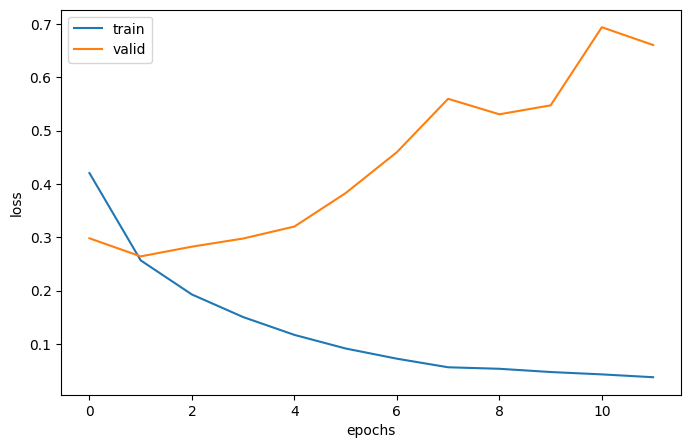

In [55]:
lstm_cnn.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
model_path = "./model/bank_app_review_lstm_cnn.keras"
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                            save_best_only=True,
                            verbose=1)
lstm_cnn_history = lstm_cnn.fit(X_train, y_train, epochs=1000, batch_size=128,
                         validation_data=(X_valid, y_valid),
                         callbacks=[early_stop, checkpoint])
plt.figure(figsize=(8, 5))
plt.plot(lstm_cnn_history.history['loss'])
plt.plot(lstm_cnn_history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'valid'])
plt.show()

In [56]:
print(lstm_cnn.evaluate(X_valid, y_valid))

209/209 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.8972 - auc: 0.9558 - loss: 0.2605
[0.26416894793510437, 0.8949655294418335, 0.9547276496887207]


In [57]:
pred = lstm_cnn.predict(X_valid)
pred

209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step


array([[0.97531474],
       [0.9691027 ],
       [0.01678027],
       ...,
       [0.9735877 ],
       [0.13665442],
       [0.9488312 ]], dtype=float32)

In [58]:
pred.shape

(6674, 1)

In [59]:
pred = pd.DataFrame(pred)

In [61]:
y_valid = pd.DataFrame(y_valid.reset_index(drop=True))
y_valid

,is_good
0,1
1,1
2,0
3,1
4,0
...,...
6669,0
6670,1
6671,1
6672,0


In [64]:
result = pd.concat([y_valid, pred], axis=1)
result.columns = ['is_good', 'pred']
result

,is_good,pred
0,1,0.975315
1,1,0.969103
2,0,0.016780
3,1,0.984055
4,0,0.026027
...,...,...
6669,0,0.060686
6670,1,0.979136
6671,1,0.973588
6672,0,0.136654


In [65]:
result['pred'] = result['pred'].apply(lambda x: 1 if x > 0.5 else 0)

In [66]:
from sklearn.metrics import classification_report
print(classification_report(result['is_good'], result['pred']))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      2702
           1       0.93      0.89      0.91      3972

    accuracy                           0.89      6674
   macro avg       0.89      0.90      0.89      6674
weighted avg       0.90      0.89      0.90      6674



# Attention => GPT
- RNN이나 LSTM은 전체 문장을 기억
- 중요한 단어에만 집중

In [9]:
# !pip install attention

In [70]:
from attention import Attention
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Add

In [71]:
inputs = Input(shape=(max_length,))
x = Embedding(input_dim=word_size, output_dim=128)(inputs)
x = Dropout(0.3)(x)

# 양방향 LSTM
x = Bidirectional(LSTM(128, return_sequences=True))(x)

# 멀티헤드 어텐션
attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
attn_output = Dropout(0.3)(attn_output)
x = Add()([x, attn_output])
x = LayerNormalization()(x)
x = GlobalAveragePooling1D()(x)

# DNN
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

# 출력층
outputs = Dense(1, activation='sigmoid')(x)
attn_model = Model(inputs=inputs, outputs=outputs)
attn_model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 302)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 302, 128)  │  1,665,408 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 302, 128)  │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 302, 256)  │    263,168 │ dropout_8[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 302, 256)  │    263,168 │ bidirectional_4[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 302, 256)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 302, 256)  │          0 │ bidirectional_4[… │
│                     │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 302, 256)  │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      2,080 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         33 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,235,521 (8.53 MB)

 Trainable params: 2,235,521 (8.53 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
attn_model.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
model_path = "./model/bank_app_review_attn_model.keras"
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                            save_best_only=True,
                            verbose=1)
attn_model_history = attn_model.fit(X_train, y_train, epochs=1000, batch_size=32,
                         validation_data=(X_valid, y_valid),
                         callbacks=[early_stop, checkpoint])
plt.figure(figsize=(8, 5))
plt.plot(attn_model_history.history['loss'])
plt.plot(attn_model_history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'valid'])
plt.show()

Epoch 1/1000
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6737 - auc: 0.6995 - loss: 0.5820
Epoch 1: val_loss improved from inf to 0.26883, saving model to ./model/bank_app_review_attn_model.keras
487/487 ━━━━━━━━━━━━━━━━━━━━ 153s 292ms/step - accuracy: 0.6740 - auc: 0.6999 - loss: 0.5817 - val_accuracy: 0.8915 - val_auc: 0.9548 - val_loss: 0.2688
Epoch 2/1000
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9150 - auc: 0.9580 - loss: 0.2430
Epoch 2: val_loss improved from 0.26883 to 0.25747, saving model to ./model/bank_app_review_attn_model.keras
487/487 ━━━━━━━━━━━━━━━━━━━━ 164s 337ms/step - accuracy: 0.9150 - auc: 0.9580 - loss: 0.2430 - val_accuracy: 0.8966 - val_auc: 0.9568 - val_loss: 0.2575
Epoch 3/1000
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9317 - auc: 0.9693 - loss: 0.1998
Epoch 3: val_loss did not improve from 0.25747
487/487 ━━━━━━━━━━━━━━━━━━━━ 203s 417ms/step - accuracy: 0.9317 - auc: 0.9693 - loss: 0.1998 - val_accuracy: 0.8926 - val

KeyboardInterrupt: 

In [1]:
print(attn_model.evaluate(X_valid, y_valid))

In [2]:
pred = attn_model.predict(X_valid)
pred

In [3]:
pred.shape

In [4]:
pred = pred.DataFrame(pred)

In [5]:
y_valid = pd.DataFrame(y_valid.reset_index(drop=True))
y_valid

In [6]:
result = pd.concat([y_valid, pred], axis=1)
result

In [7]:
result.columns = ['is_good', 'pred']
result

In [8]:
result['pred'] = result['pred'].apply(lambda x: 1 if x > 0.5 else 0)

In [11]:
from sklearn.metrics import classification_report
print(classification_report(result['is_good'], result['pred']))